In [1]:
# reference: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
! nvidia-smi

Sat Sep 26 18:15:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    73W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# torch downgrade for deployment of face recog
!pip install torch==1.5.0 torchvision==0.6.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [3]:
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import sys
S7_PROJECT_PATH = '/content/drive/My Drive/TSAI/TSAI-2/S7/Save_Model/'

In [6]:
# !7z x '/content/drive/My Drive/TSAI/TSAI-2/S7/Save_Model/CARS.7z' -o'/content/' -ir!'CARS/RED/*.jpg'

In [7]:
from __future__ import print_function
# %matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import time
from torch.nn import functional as F

from pathlib import Path
from torchsummary import summary

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [8]:
# Root directory for dataset
dataroot = "/content/CARS"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 32

# number of channels
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Number of training epochs
num_epochs = 300
# Learning rate for optimizers
lr = 0.001

# Beta1 hyperparam for Adam optimizers
beta1 = 0.95

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# image size after transformation
image_size=128

Data
----


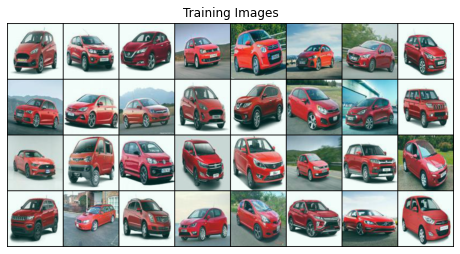

In [9]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.570838093757629, 0.479552984237671, 0.491760671138763), (0.279659748077393, 0.309973508119583, 0.311098515987396))
                           ]))

# creating trainset and testset
trainset,testset = torch.utils.data.random_split(dataset, [int(.95*len(dataset))+1, int(.05*len(dataset))]) 

# Create the dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(trainloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Variational Auto Encoder



In [10]:
from typing import List, Callable, Union, Any, TypeVar, Tuple
Tensor = TypeVar('torch.tensor')
class VAE(nn.Module):
    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super(VAE, self).__init__()

        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*16, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*16, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 16)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 512, 4, 4)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input)


        #kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
        kld_loss = -0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp())
        kld_loss = kld_loss/kld_weight
        # loss = recons_loss + kld_weight * kld_loss
        loss = recons_loss + kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':-kld_loss}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

Now, as with the generator, we can create the discriminator, apply the
``weights_init`` function, and print the model’s structure.




In [11]:
vae = VAE(in_channels=nc, latent_dim=nz, hidden_dims=[32,64,128,256,512])

# Create the Discriminator
vae = vae.to(device)

In [12]:
summary(vae, input_size=(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
       BatchNorm2d-2           [-1, 32, 64, 64]              64
         LeakyReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
       BatchNorm2d-5           [-1, 64, 32, 32]             128
         LeakyReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 16, 16]          73,856
       BatchNorm2d-8          [-1, 128, 16, 16]             256
         LeakyReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10            [-1, 256, 8, 8]         295,168
      BatchNorm2d-11            [-1, 256, 8, 8]             512
        LeakyReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 512, 4, 4]       1,180,160
      BatchNorm2d-14            [-1, 51

Loss Functions and Optimizers

In [13]:
# optimizer
optimizer = optim.Adam(vae.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=0.0)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.95, min_lr=1e-5)

In [14]:
!mkdir results
!mkdir samples
!mkdir checkpoints

mkdir: cannot create directory ‘checkpoints’: File exists


In [15]:
trainloss=[]
testloss=[]
img_list=[]
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        loss = vae.loss_function(*vae(data), M_N=data.size(0)*data.size(1)*data.size(2)*data.size(3))
        loss['loss'].backward()
        train_loss += loss['loss'].item()
        optimizer.step()
        # scheduler.step(train_loss)
        if batch_idx % 4 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tRecLoss: {:.6f}\tKLDLoss: {:.6f}\tLR:{:.8f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader),
                loss['loss'].item(), loss['Reconstruction_Loss'].item(), loss['KLD'].item(),optimizer.param_groups[0]['lr']))
    trainloss.append(train_loss / len(trainloader.dataset))
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(trainloader.dataset)))

def test(epoch):
    vae.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(testloader):
            data = data.to(device)
            results = vae(data)
            test_loss += vae.loss_function(*results, M_N=data.size(0)*data.size(1)*data.size(2)*data.size(3))['loss'].item() #M_N=batch_size/len(testset)
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([results[1][:n],
                                      results[0][:n]])
                img_list.append(vutils.make_grid(comparison.cpu(), padding=2, normalize=True))
                vutils.save_image(comparison.cpu(),
                         'results/reconstruction_' + f'{epoch:04}' + '.jpg', nrow=n, normalize=True)
                scheduler.step(test_loss)
    test_loss /= len(testloader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    testloss.append(test_loss)

Training for 300 epochs

In [16]:
for epoch in range(1, num_epochs+1):
        train(epoch)
        test(epoch)
        # scheduler.step()
        # optimizer.step()
        with torch.no_grad():
            sample = vae.sample(num_samples=64, current_device=device).cpu()
            vutils.save_image(sample,
                       'samples/sample_' + f'{epoch:04}' + '.jpg', normalize=True)

Train Epoch: 1 [0/1390 (0%)]	Loss: 1.299513	RecLoss: 1.299258	KLDLoss: -0.000256	LR:0.00100000
Train Epoch: 1 [128/1390 (9%)]	Loss: 1.082014	RecLoss: 1.074926	KLDLoss: -0.007088	LR:0.00100000
Train Epoch: 1 [256/1390 (18%)]	Loss: 0.975662	RecLoss: 0.967405	KLDLoss: -0.008257	LR:0.00100000
Train Epoch: 1 [384/1390 (27%)]	Loss: 0.840101	RecLoss: 0.832400	KLDLoss: -0.007701	LR:0.00100000
Train Epoch: 1 [512/1390 (36%)]	Loss: 0.734521	RecLoss: 0.726052	KLDLoss: -0.008469	LR:0.00100000
Train Epoch: 1 [640/1390 (45%)]	Loss: 0.650411	RecLoss: 0.637107	KLDLoss: -0.013304	LR:0.00100000
Train Epoch: 1 [768/1390 (55%)]	Loss: 0.629893	RecLoss: 0.615304	KLDLoss: -0.014589	LR:0.00100000
Train Epoch: 1 [896/1390 (64%)]	Loss: 0.628959	RecLoss: 0.615803	KLDLoss: -0.013156	LR:0.00100000
Train Epoch: 1 [1024/1390 (73%)]	Loss: 0.595403	RecLoss: 0.579948	KLDLoss: -0.015455	LR:0.00100000
Train Epoch: 1 [1152/1390 (82%)]	Loss: 0.600338	RecLoss: 0.581607	KLDLoss: -0.018730	LR:0.00100000
Train Epoch: 1 [1280/1

Train for 600 Epochs

In [29]:
for epoch in range(num_epochs+2, num_epochs*2+1):
        train(epoch)
        test(epoch)
        # scheduler.step()
        # optimizer.step()
        with torch.no_grad():
            sample = vae.sample(num_samples=64, current_device=device).cpu()
            vutils.save_image(sample,
                       'samples/sample_' + f'{epoch:04}' + '.jpg', normalize=True)

Train Epoch: 302 [0/1390 (0%)]	Loss: 0.142592	RecLoss: 0.135778	KLDLoss: -0.006815	LR:0.00037735
Train Epoch: 302 [128/1390 (9%)]	Loss: 0.139888	RecLoss: 0.133267	KLDLoss: -0.006621	LR:0.00037735
Train Epoch: 302 [256/1390 (18%)]	Loss: 0.164708	RecLoss: 0.158339	KLDLoss: -0.006369	LR:0.00037735
Train Epoch: 302 [384/1390 (27%)]	Loss: 0.153299	RecLoss: 0.146563	KLDLoss: -0.006736	LR:0.00037735
Train Epoch: 302 [512/1390 (36%)]	Loss: 0.140004	RecLoss: 0.133286	KLDLoss: -0.006718	LR:0.00037735
Train Epoch: 302 [640/1390 (45%)]	Loss: 0.145204	RecLoss: 0.138604	KLDLoss: -0.006601	LR:0.00037735
Train Epoch: 302 [768/1390 (55%)]	Loss: 0.133794	RecLoss: 0.127156	KLDLoss: -0.006639	LR:0.00037735
Train Epoch: 302 [896/1390 (64%)]	Loss: 0.155722	RecLoss: 0.149087	KLDLoss: -0.006635	LR:0.00037735
Train Epoch: 302 [1024/1390 (73%)]	Loss: 0.129526	RecLoss: 0.123144	KLDLoss: -0.006382	LR:0.00037735
Train Epoch: 302 [1152/1390 (82%)]	Loss: 0.152951	RecLoss: 0.146452	KLDLoss: -0.006499	LR:0.00037735
Tr

Train for 900 Epochs

In [41]:
for epoch in range(num_epochs*2+1, num_epochs*3+1):
        train(epoch)
        test(epoch)
        # scheduler.step()
        # optimizer.step()
        with torch.no_grad():
            sample = vae.sample(num_samples=64, current_device=device).cpu()
            vutils.save_image(sample,
                       'samples/sample_' + f'{epoch:04}' + '.jpg', normalize=True)

Train Epoch: 601 [0/1390 (0%)]	Loss: 0.136726	RecLoss: 0.130783	KLDLoss: -0.005943	LR:0.00008974
Train Epoch: 601 [128/1390 (9%)]	Loss: 0.167768	RecLoss: 0.162047	KLDLoss: -0.005721	LR:0.00008974
Train Epoch: 601 [256/1390 (18%)]	Loss: 0.135527	RecLoss: 0.129651	KLDLoss: -0.005876	LR:0.00008974
Train Epoch: 601 [384/1390 (27%)]	Loss: 0.132769	RecLoss: 0.126684	KLDLoss: -0.006085	LR:0.00008974
Train Epoch: 601 [512/1390 (36%)]	Loss: 0.124276	RecLoss: 0.118248	KLDLoss: -0.006029	LR:0.00008974
Train Epoch: 601 [640/1390 (45%)]	Loss: 0.147221	RecLoss: 0.141621	KLDLoss: -0.005600	LR:0.00008974
Train Epoch: 601 [768/1390 (55%)]	Loss: 0.142843	RecLoss: 0.137201	KLDLoss: -0.005642	LR:0.00008974
Train Epoch: 601 [896/1390 (64%)]	Loss: 0.123814	RecLoss: 0.117828	KLDLoss: -0.005986	LR:0.00008974
Train Epoch: 601 [1024/1390 (73%)]	Loss: 0.127556	RecLoss: 0.121886	KLDLoss: -0.005670	LR:0.00008974
Train Epoch: 601 [1152/1390 (82%)]	Loss: 0.151055	RecLoss: 0.145285	KLDLoss: -0.005770	LR:0.00008974
Tr

In [42]:
!7z a '{S7_PROJECT_PATH}results.7z' '/content/results/'
!7z a '{S7_PROJECT_PATH}samples.7z' '/content/samples/'


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Open archive: /content/drive/My Drive/TSAI/TSAI-2/S7/Save_Model/results.7z
--
Path = /content/drive/My Drive/TSAI/TSAI-2/S7/Save_Model/results.7z
Type = 7z
Physical Size = 20250090
Headers Size = 6240
Method = LZMA2:24
Solid = +
Blocks = 1

Scanning the drive:
  0M Scan  /content/                    1 folder, 899 files, 44525628 bytes (43 MiB)

Updating archive: /content/drive/My Drive/TSAI/TSAI-2/S7/Save_Model/results.7z

Items to compress: 900

  0%      2% 39 U results/reconstruction_0040.jpg                                           5% 67 U results/reconstruction_0068.jpg                                         

Results


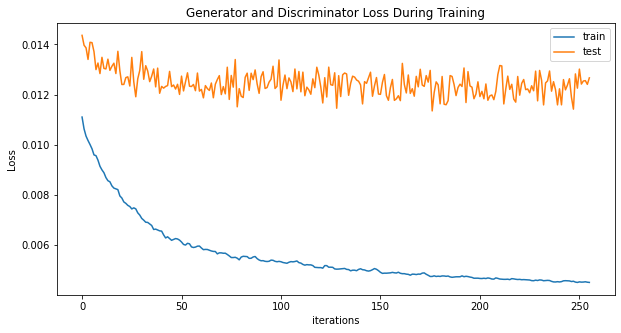

In [43]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(trainloss[10:266],label="train")
plt.plot(testloss[10:266],label="test")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

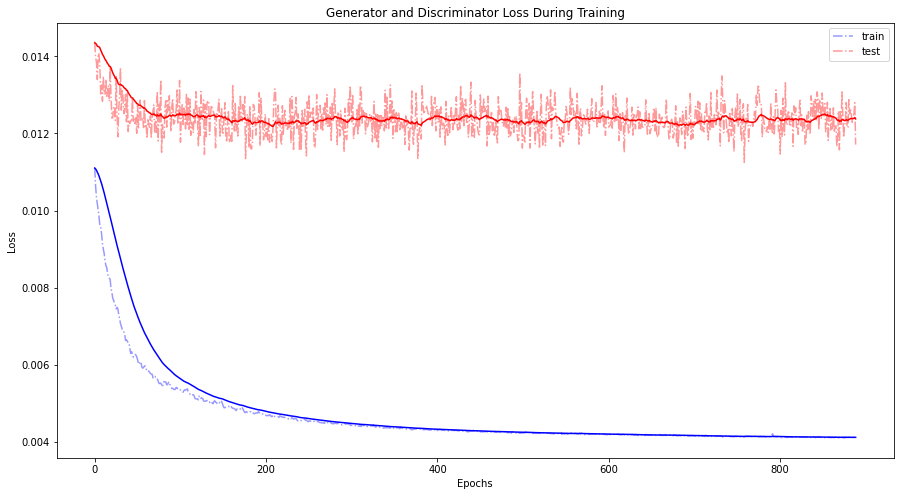

In [44]:
def smooth_curv(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return np.array(smoothed)

plt.figure(figsize=(15, 8))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(trainloss[10:], 'b-.',label="train", alpha=0.4)
plt.plot(testloss[10:], 'r-.', label="test", alpha=0.4)
plt.plot(smooth_curv(trainloss[10:], 0.95), 'b')
plt.plot(smooth_curv(testloss[10:], 0.95), 'r')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Visualization of G’s progression**

Remember how we saved the generator’s output on the fixed_noise batch
after every epoch of training. Now, we can visualize the training
progression of G with an animation. Press the play button to start the
animation.




In [47]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by
side.




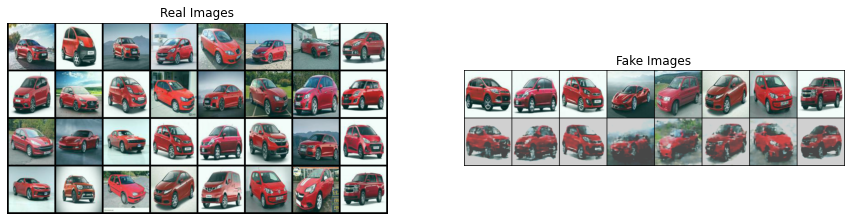

In [45]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(testloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# Save the Model

In [46]:
torch.save(vae, f'{S7_PROJECT_PATH}red_car_gan_generator.pt')
traced_model = torch.jit.trace(vae.to('cpu'), torch.randn(1, 3, 128, 128))
traced_model.save(f'{S7_PROJECT_PATH}red_car_gan_generator.traced.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [36]:
# !rm -r CARS
# !rm -r results
# !rm -r samples

In [37]:
# drive.flush_and_unmount()

In [50]:
# !sudo apt install imagemagick
ani.save(f'{S7_PROJECT_PATH}cars.gif', writer='imagemagick', fps=60)

MovieWriter stderr:
convert-im6.q16: DistributedPixelCache '127.0.0.1' @ error/distribute-cache.c/ConnectPixelCacheServer/244.
convert-im6.q16: cache resources exhausted `-' @ error/cache.c/OpenPixelCache/3984.
convert-im6.q16: no images defined `/content/drive/My Drive/TSAI/TSAI-2/S7/Save_Model/cars.gif' @ error/convert.c/ConvertImageCommand/3258.



CalledProcessError: ignored